<a href="https://colab.research.google.com/github/shahuzi/tf2.0_learning/blob/master/3_Basic_regression_Predict_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


### 获取数据
首先下载数据集。

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [3]:
# 使用 pandas 导入数据集。
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 数据清洗

数据集中包括一些未知值。

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# 为了保证这个初始示例的简单性，删除这些行。
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# `"Origin"` 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 拆分训练数据集和测试数据集

现在需要将数据集拆分为一个训练数据集和一个测试数据集。

我们最后将使用测试数据集对模型进行评估。

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 数据检查

快速查看训练集中几对列的联合分布。

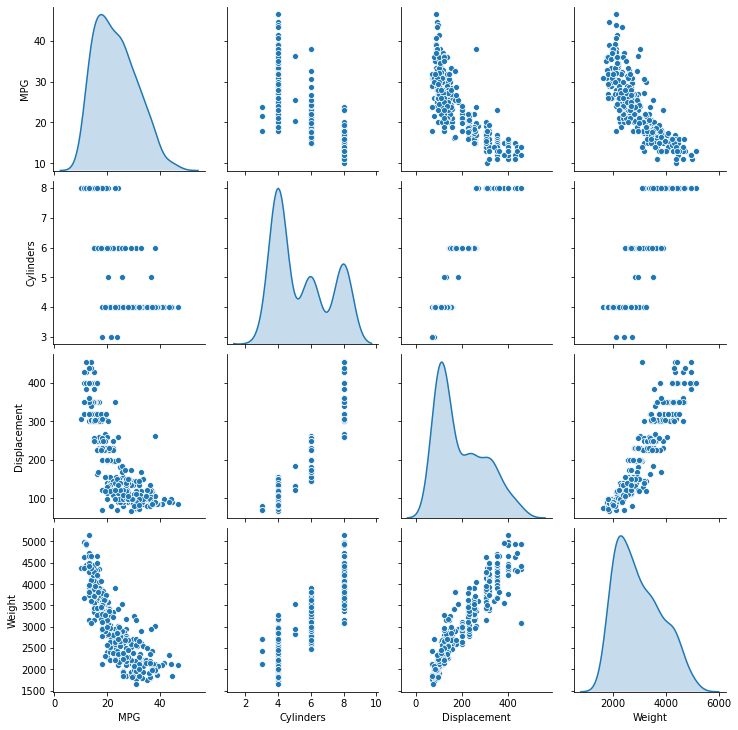

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
# 也可以查看总体的数据统计:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 从标签中分离特征

将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 数据规范化

再次审视下上面的 `train_stats` 部分，并注意每个特征的范围有什么不同。

使用不同的尺度和范围对特征归一化是好的实践。尽管模型*可能* 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

我们将会使用这个已经归一化的数据来训练模型。

警告: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据，以及我们之前所获得独热码。这些数据包含测试数据集以及生产环境中所使用的实时数据。

In [13]:
train_stats = normed_train_data.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


In [14]:
train_stats['mean']

Cylinders       2.093159e-16
Displacement    1.018294e-16
Horsepower     -1.909301e-17
Weight         -9.723291e-17
Acceleration    2.688832e-15
Model Year      9.561531e-16
USA             6.081476e-17
Europe          8.485781e-18
Japan           3.164489e-17
Name: mean, dtype: float64

## 模型


### 构建模型

让我们来构建我们自己的模型。这里，我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层。模型的构建步骤包含于一个名叫 'build_model' 的函数中，稍后我们将会创建第二个模型。 两个密集连接的隐藏层。

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 `model.predict` 。

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.2518241 ],
       [ 0.06491353],
       [ 0.22829625],
       [-0.07680334],
       [-0.16407539],
       [ 0.09606589],
       [-0.2211045 ],
       [-0.2817486 ],
       [ 0.0015303 ],
       [-0.22125094]], dtype=float32)

它似乎在工作，并产生了预期的形状和类型的结果

### 训练模型

对模型进行1000个周期的训练，并在 `history` 对象中记录训练和验证的准确性。

In [18]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用 `history` 对象中存储的统计信息可视化模型的训练进度。

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.054101,1.164213,3.054101,9.139528,2.382024,9.139528,995
996,2.871969,1.111777,2.871969,9.053936,2.361596,9.053936,996
997,2.793247,1.123787,2.793247,8.846116,2.326701,8.846116,997
998,3.070967,1.117436,3.070967,9.100414,2.374680,9.100414,998
999,2.789538,1.094230,2.789538,8.888643,2.351520,8.888643,999


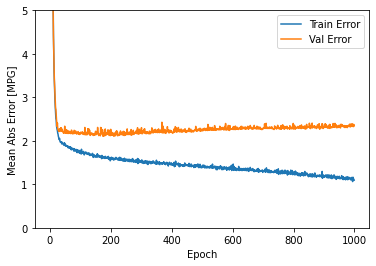

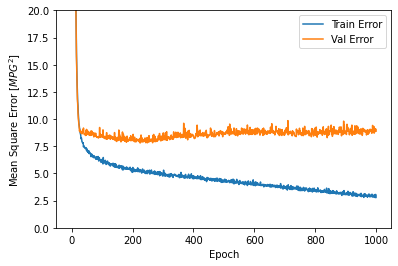

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 `model.fit` 调用，当验证值没有提高上是自动停止训练。
我们将使用一个 *EarlyStopping callback* 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

你可以从[这里](https://tensorflow.google.cn/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping)学习到更多的回调。


...............................................................

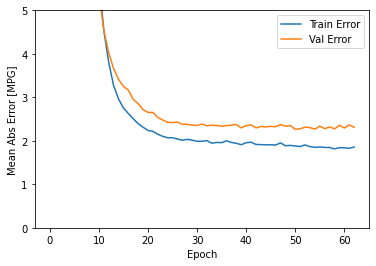

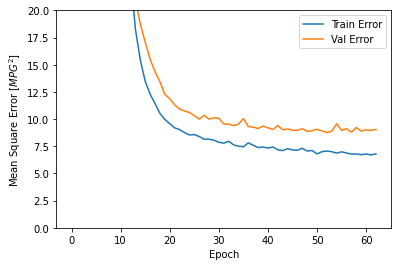

In [21]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 **测试集** 来泛化模型的效果如何，我们在训练模型时没有使用测试集。这告诉我们，当我们在现实世界中使用这个模型时，我们可以期望它预测得有多好。

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.2949 - mae: 1.9602 - mse: 6.2949
Testing set Mean Abs Error:  1.96 MPG


### 做预测
 
最后，使用测试集中的数据预测 MPG 值:

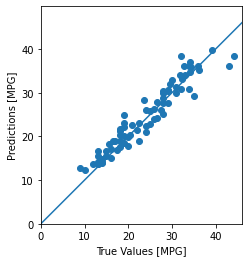

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

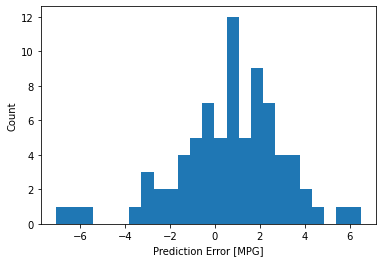

In [24]:
# 这看起来我们的模型预测得相当好。我们来看下误差分布。
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

## 结论

本笔记本 (notebook) 介绍了一些处理回归问题的技术。

* 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
* 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
* 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
* 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
* 早期停止是一种防止过度拟合的有效技术。